In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# 1. Carga y Exploración Inicial de Datos
data = pd.read_csv("C:/Users/ivan_/Documents/bootcamp/machine_learning/core06/archive/insurance.csv")

# Mostrar las primeras 5 filas, información de columnas y estadísticas descriptivas
print("Primeras 5 filas:")
print(data.head())
print("\nInformación de las columnas:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())

# Verificar valores faltantes
print("\nValores faltantes por columna:")
print(data.isnull().sum())

# Detectar valores atípicos utilizando el rango intercuartílico (IQR)
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

bmi_outliers = detect_outliers(data, 'bmi')
charges_outliers = detect_outliers(data, 'charges')
print(f"\nOutliers en 'bmi': {len(bmi_outliers)}")
print(f"Outliers en 'charges': {len(charges_outliers)}")



Primeras 5 filas:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Información de las columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Estadísticas descriptivas:
               

In [ ]:
# 2. Preprocesamiento de Datos
# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')  # O 'median' o 'most_frequent'
data[['bmi']] = imputer.fit_transform(data[['bmi']])

# Codificar variables categóricas utilizando One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(data[['sex', 'smoker', 'region']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['sex', 'smoker', 'region']))
data = pd.concat([data, encoded_df], axis=1)
data.drop(['sex', 'smoker', 'region'], axis=1, inplace=True)

# Escalar características numéricas utilizando StandardScaler
scaler = StandardScaler()
data[['age', 'bmi', 'children']] = scaler.fit_transform(data[['age', 'bmi', 'children']])


In [7]:
# 3. Implementación de Modelos de Clasificación
# Convertir la variable objetivo 'charges' a una variable categórica
median_charges = data['charges'].median()
data['charges_category'] = (data['charges'] > median_charges).astype(int)

# Dividir los datos en conjuntos de entrenamiento y prueba
X = data.drop(['charges', 'charges_category'], axis=1)
y = data['charges_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los modelos de clasificación
models = {
    "LogisticRegression": LogisticRegression(max_iter=10000),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

# Entrenar los modelos
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Evaluar el rendimiento inicial de los modelos utilizando validación cruzada
cv_scores = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores[model_name] = scores

# Imprimir los resultados de la validación cruzada
for model_name, scores in cv_scores.items():
    print(f"{model_name}:")
    print(f"  Puntajes de validación cruzada: {scores}")
    print(f"  Precisión promedio: {scores.mean()}\n")

# 4. Optimización de Hiperparámetros
# Implementar GridSearchCV para optimizar los hiperparámetros
param_grids = {
    "LogisticRegression": {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
    "KNeighborsClassifier": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ['uniform', 'distance'],
        "p": [1, 2]
    },
    "DecisionTreeClassifier": {
        "max_depth": [3, 5, 7, 9],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}

grid_search_results = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    grid_search_results[model_name] = grid_search

# Imprimir los mejores hiperparámetros de GridSearchCV
for model_name, grid_search in grid_search_results.items():
    print(f"Mejores hiperparámetros para {model_name} (GridSearchCV): {grid_search.best_params_}")

# Implementar RandomizedSearchCV como método alternativo de optimización
random_search_results = {}
for model_name, model in models.items():
    random_search = RandomizedSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy', n_iter=10)
    random_search.fit(X_train, y_train)
    random_search_results[model_name] = random_search

# Imprimir los mejores hiperparámetros de RandomizedSearchCV
for model_name, random_search in random_search_results.items():
    print(f"Mejores hiperparámetros para {model_name} (RandomizedSearchCV): {random_search.best_params_}")



LogisticRegression:
  Puntajes de validación cruzada: [0.88785047 0.92523364 0.91121495 0.91588785 0.88317757]
  Precisión promedio: 0.9046728971962616

KNeighborsClassifier:
  Puntajes de validación cruzada: [0.85981308 0.90654206 0.85514019 0.87383178 0.88785047]
  Precisión promedio: 0.8766355140186917

DecisionTreeClassifier:
  Puntajes de validación cruzada: [0.86448598 0.92523364 0.85981308 0.89252336 0.90186916]
  Precisión promedio: 0.888785046728972



c:\Users\ivan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ivan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ivan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ivan_\AppDat

Mejores hiperparámetros para LogisticRegression (GridSearchCV): {'C': 1, 'penalty': 'l2'}
Mejores hiperparámetros para KNeighborsClassifier (GridSearchCV): {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Mejores hiperparámetros para DecisionTreeClassifier (GridSearchCV): {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}


c:\Users\ivan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\ivan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ivan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_trai

Mejores hiperparámetros para LogisticRegression (RandomizedSearchCV): {'penalty': 'l2', 'C': 1}
Mejores hiperparámetros para KNeighborsClassifier (RandomizedSearchCV): {'weights': 'distance', 'p': 1, 'n_neighbors': 9}
Mejores hiperparámetros para DecisionTreeClassifier (RandomizedSearchCV): {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}


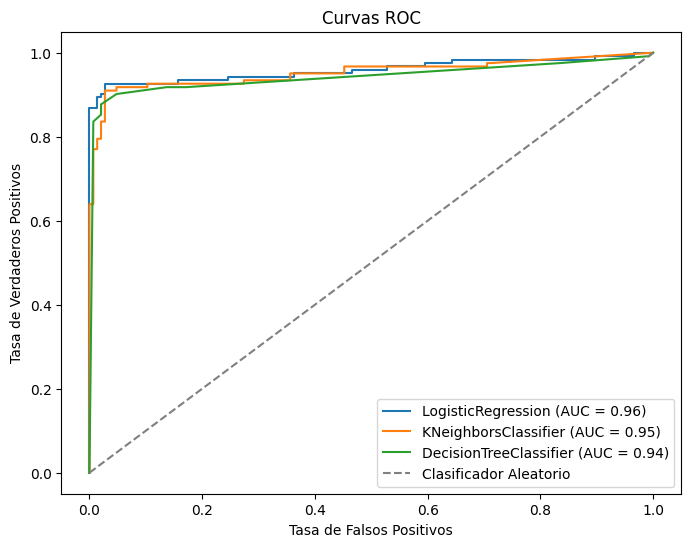

In [8]:
# 5. Evaluación de Modelos
# Evaluar los modelos optimizados utilizando métricas de rendimiento
best_models = {}
for model_name, grid_search in grid_search_results.items():
    best_models[model_name] = grid_search.best_estimator_

for model_name, random_search in random_search_results.items():
    if model_name not in best_models:
        best_models[model_name] = random_search.best_estimator_

# Calcular las probabilidades de predicción y las métricas ROC para cada modelo
roc_results = {}
for model_name, model in best_models.items():
    # Obtener las probabilidades de la clase positiva
    y_probs = model.predict_proba(X_test)[:, 1]

    # Calcular la tasa de falsos positivos (FPR), la tasa de verdaderos positivos (TPR)
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Calcular el área bajo la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Almacenar los resultados
    roc_results[model_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

# Trazar las curvas ROC para cada modelo
plt.figure(figsize=(8, 6))
for model_name, results in roc_results.items():
    plt.plot(results['fpr'], results['tpr'], label=f'{model_name} (AUC = {results["auc"]:.2f})')

# Añadir la línea diagonal para el clasificador aleatorio
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Clasificador Aleatorio')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend()

# Mostrar la gráfica
plt.show()